# Kalman-Filter

In [1]:
import numpy as np
import datetime as dt # for date and time operations
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d # for 3d plot
from matplotlib import cm
import matplotlib.gridspec as gridspec

%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display
from scipy.linalg import inv
import FMNM.Kalman_filter as KF

# Real market data

In [2]:
filename = "data/" + "historical_data.csv"
data = pd.read_csv(filename, index_col="Date", parse_dates=True)
data.tail()

,AAPL,EXO.MI,FB,GOOGL,UBS,^GSPC,^IXIC,^TNX,^VIX
Date,,,,,,,,,
2019-10-28,249.050003,62.939999,189.399994,1288.979980,11.95,3039.419922,8325.990234,1.853,13.11
2019-10-29,243.289993,62.160000,189.309998,1260.660034,12.08,3036.889893,8276.849609,1.835,13.20
2019-10-30,243.259995,65.019997,188.250000,1260.699951,11.84,3046.770020,8303.980469,1.798,12.33
2019-10-31,248.759995,68.720001,191.649994,1258.800049,11.77,3037.560059,8292.360352,1.691,13.22
2019-11-01,255.820007,69.459999,193.619995,1272.250000,11.96,3066.909912,8386.400391,1.728,12.30


<a id='sec1.1'></a>
### Data cleaning

In [3]:
data[data.isna().any(axis=1)].tail() # check if there is any missing data

,AAPL,EXO.MI,FB,GOOGL,UBS,^GSPC,^IXIC,^TNX,^VIX
Date,,,,,,,,,
2019-05-01,208.918625,NaN,193.029999,1173.319946,12.593584,2923.729980,8049.640137,2.511,14.80
2019-05-27,NaN,59.554962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-04,NaN,64.400002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-15,201.740005,NaN,182.589996,1169.319946,10.160000,2847.600098,7766.620117,1.529,21.18
2019-09-02,NaN,61.840000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
(data < 1e-2).any() # check if there is any data less than 1e-2

AAPL      False
EXO.MI    False
FB        False
GOOGL     False
UBS       False
^GSPC     False
^IXIC     False
^TNX      False
^VIX      False
dtype: bool

In [5]:
df = data[["GOOGL", "^GSPC"]] # only use the data of GOOGL and ^GSPC (^GSPC is the S&P 500 index)

In [6]:
history_len = 1000  # lenght of the time series
df.sort_index(inplace=True, ascending=True)  # not necessary in general, but useful
df = df.dropna(axis=1, how="all")  # drops columns with all NaNs
df = df.dropna(axis=0, how="all")  # drops rows with at least one NaN
df = df[-history_len:] # keep only the last history_len days
df = df.ffill()  # Forward fill
print("Are there still some NaNs? ")
df.isnull().any() # check if there are still NaNs

Are there still some NaNs? 


GOOGL    False
^GSPC    False
dtype: bool

In [7]:
returns = "log-returns" # "log-returns", "linear-returns", "total-returns"

if returns == "log-returns":
    ret = np.log(df / df.shift())[1:] # this is calculated as log(P_t/P_{t-1})
elif returns == "linear-returns":
    ret = df.pct_change()[1:] # this is calculated as (P_t - P_{t-1})/P_{t-1}
elif returns == "total-returns":
    ret = df / df.shift()[1:] - 1 # this is calculated as (P_t - P_{t-1})/P_{t-1}

##### Plot

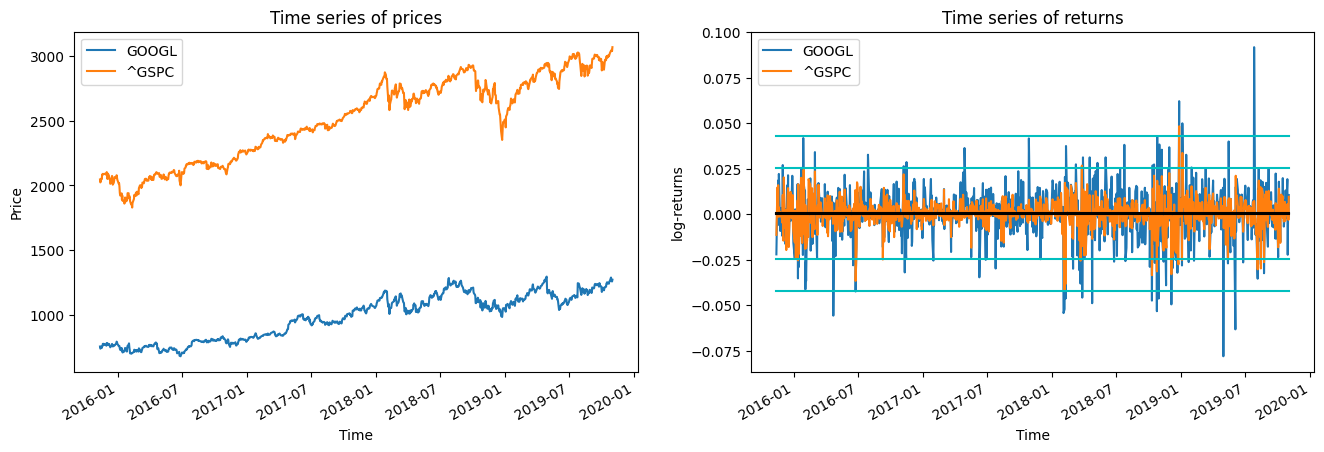

In [8]:
NOSD = 3  # Number Of Standard Deviations
mu = ret.mean() # mean of the returns
sig = ret.std() # standard deviation of the returns
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(ax=ax1)
ax1.set_title("Time series of prices")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ret.plot(ax=ax2)
ax2.set_title("Time series of returns")
ax2.set_xlabel("Time")
ax2.set_ylabel(returns)
ax2.plot(ret.index, len(ret) * [mu], color="k")
ax2.plot(ret.index, len(ret) * [mu + NOSD * sig], color="c")
ax2.plot(ret.index, len(ret) * [mu - NOSD * sig], color="c")
plt.show()

In [9]:
median = ret.median() # median of the returns
MAD = ret.apply(ss.median_abs_deviation) # Median Absolute Deviation
sig_robust = MAD * 1.4826 # 1.4826 is the constant to make MAD consistent with the standard deviation
print("STD DEV: \n", sig)
print("")
print("Robust STD DEV: \n", sig_robust);

STD DEV: 
 GOOGL    0.014242
^GSPC    0.008324
dtype: float64

Robust STD DEV: 
 GOOGL    0.010268
^GSPC    0.005255
dtype: float64


In [10]:
outliers = ret[ret[np.abs(ret - median) > NOSD * sig_robust].any(axis=1)]  # outliers
dret = ret.drop(outliers.index)  # series of returns without outliers

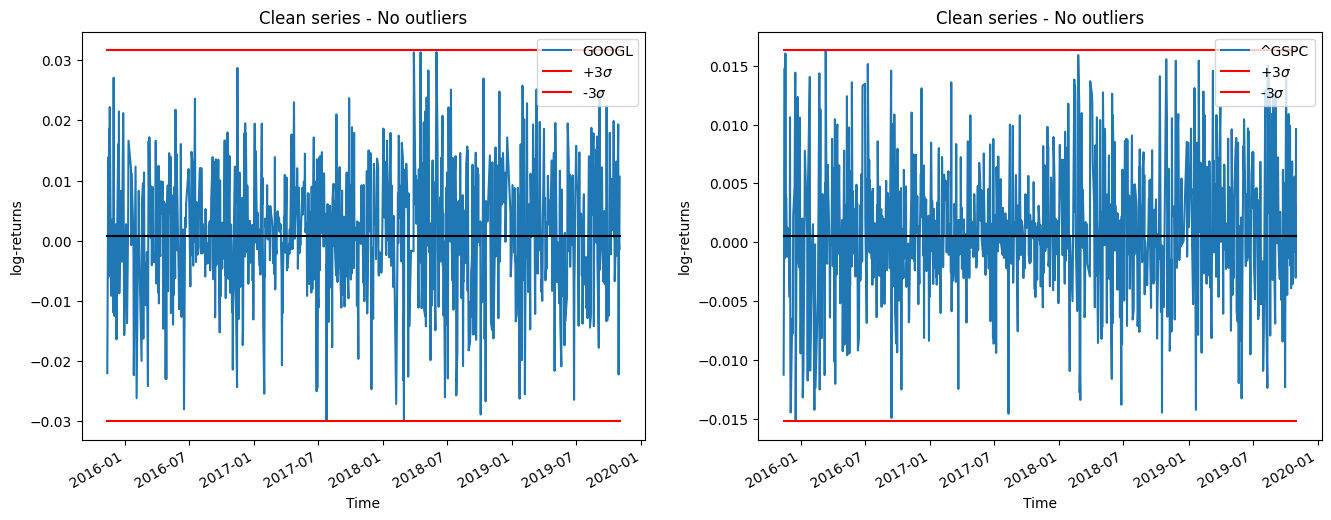

In [11]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for ax, col in zip([ax1, ax2], dret.columns):
    dret[col].plot(ax=ax)
    ax.set_title("Clean series - No outliers")
    ax.set_xlabel("Time")
    ax.set_ylabel(returns)
    ax.plot(dret.index, len(dret) * [median[col]], color="k")
    ax.plot(dret.index, len(dret) * [median[col] + NOSD * sig_robust[col]], color="r", label="+3$\sigma$")
    ax.plot(dret.index, len(dret) * [median[col] - NOSD * sig_robust[col]], color="r", label="-3$\sigma$")
    ax.legend(loc="upper right")
plt.show()

In [12]:
print(
    "We have reduced the initial DIRTY series of returns of size {} to the \
new CLEAN series of size {}.".format(
        len(ret), len(dret)
    )
)

We have reduced the initial DIRTY series of returns of size 999 to the new CLEAN series of size 911.


# Linear regression

In [13]:
X = dret[dret.columns[1]] # independent variable
Y = dret[dret.columns[0]] # dependent variable
print("In our regression Y is {} and X is {}".format(dret.columns[0], dret.columns[1]))

In our regression Y is GOOGL and X is ^GSPC


In [14]:
b_ss, a_ss, r_ss, _, std_err_ss = ss.linregress(X, Y)

print(
    "We can use one of the many python functions:\nbeta: {0:6f}, alpha: {1:6f}, R2: {2:6f}, \
standard error: {3:6f}.".format(
        b_ss, a_ss, r_ss**2, std_err_ss
    )
)

beta_tot_OLS = np.cov(X, Y, ddof=1)[0, 1] / np.var(X, ddof=1) 
alpha_tot_OLS = np.mean(Y) - beta_tot_OLS * np.mean(X)
res = Y - beta_tot_OLS * X - alpha_tot_OLS
std_eps_OLS = np.std(res, ddof=2)
print("\nOr I can estimate by myself:\nbeta: {}, alpha: {}, sigma: {}".format(beta_tot_OLS, alpha_tot_OLS, std_eps_OLS))

We can use one of the many python functions:
beta: 1.181743, alpha: 0.000058, R2: 0.428090, standard error: 0.045304.

Or I can estimate by myself:
beta: 1.1817426272884217, alpha: 5.772407285412843e-05, sigma: 0.007842859851366457


In [15]:
n = len(X)
x_mean = np.mean(X)
y_mean = np.mean(Y)
Sxx = (X - x_mean) @ (X - x_mean)
Syy = (Y - y_mean) @ (Y - y_mean)
Sxy = (X - x_mean) @ (Y - y_mean)
beta_hat = Sxy / Sxx
alpha_hat = y_mean - beta_hat * x_mean  # beta and alpha
print("beta: {} and alpha: {}".format(beta_hat, alpha_hat))
epsilon = Y - beta_hat * X - alpha_hat  # residuals
S2 = epsilon @ epsilon / (n - 2)
S = np.sqrt(S2)  # unbiased estimator
print("sigma: {}".format(S))
var_beta = S2 / Sxx  # variance of beta
var_alpha = (X @ X) * S2 / (Sxx * n)  # variance of alpha
s_b = np.sqrt(var_beta)  # standard error for beta
s_a = np.sqrt(var_alpha)  # standard error for alpha
R2 = Sxy**2 / (Sxx * Syy)
print("Standard Error for beta: ", s_b)
print("R squared: {}".format(R2))
CI_b = ss.t.interval(0.95, n - 2, loc=beta_hat, scale=s_b)
b_up = CI_b[0]
b_down = CI_b[1]
CI_a = ss.t.interval(0.95, n - 2, loc=alpha_hat, scale=s_a)
print("Confidence intervals for beta: ", CI_b)
print("Confidence intervals for alpha: ", CI_a)

beta: 1.1817426272884215 and alpha: 5.7724072854128646e-05
sigma: 0.007842859851366459
Standard Error for beta:  0.045304065992093356
R squared: 0.42809009281099913
Confidence intervals for beta:  (1.0928299019730954, 1.2706553526037476)
Confidence intervals for alpha:  (-0.00045994742925024477, 0.0005753955749585021)


The intercept $\alpha$ is (always) almost zero. Therefore it is not relevant for the future analysis.  

##### Plot:

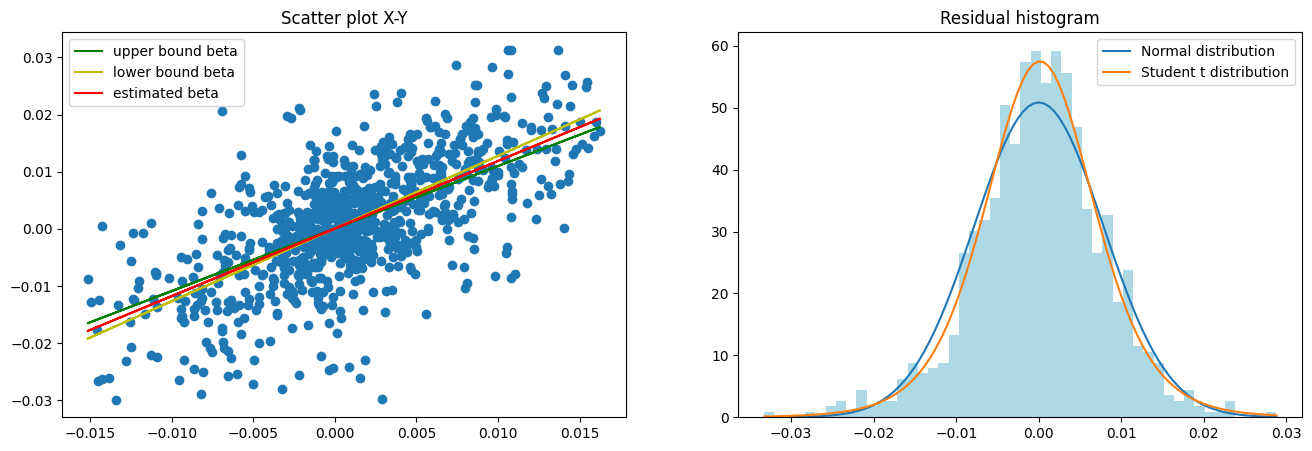

In [16]:
x = np.linspace(res.min(), res.max(), 100)  # res are the residuals

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(X, Y)
ax1.set_title("Scatter plot X-Y")
ax1.plot(X, alpha_hat + b_up * X, color="g", label="upper bound beta")
ax1.plot(X, alpha_hat + b_down * X, color="y", label="lower bound beta")
ax1.plot(X, alpha_hat + beta_hat * X, color="red", label="estimated beta")
ax1.legend(loc="upper left")
ax2.plot(x, ss.norm.pdf(x, 0, S), label="Normal distribution")
params = ss.t.fit(res)
ax2.plot(x, ss.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax2.hist(res, bins=50, density=True, facecolor="LightBlue")
ax2.legend()
ax2.set_title("Residual histogram")
plt.show()

In [17]:
print("Degrees of freedom of fitted t distribution: ", params[0])

Degrees of freedom of fitted t distribution:  7.247881899338388


## Kalman Regression Model

In [18]:
Y = dret.columns[0]
X = dret.columns[1]

In [19]:
training_size = 250
ret_train = dret.iloc[:training_size]
ret_test = dret.iloc[training_size:]

In [20]:
beta_tr, alpha_tr, _, _, _ = ss.linregress(ret_train[X], ret_train[Y])
resid_tr = ret_train[Y] - beta_tr * ret_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)  # a possible initial guess for var_eps
print("In the training set the OLS estimators of")
print("alpha_tr = ", alpha_tr)
print("beta_tr = ", beta_tr)
print("var_eps = ", var_eps_ols)

In the training set the OLS estimators of
alpha_tr =  0.00022764404115736684
beta_tr =  0.975177255166134
var_eps =  6.286775484858259e-05


### Rolling alpha and beta

In [21]:
rolling_window = 50
rolling_beta = []
rolling_std_err = []
rolling_alpha = []

for i in range(len(ret_test)):
    ret_temp = ret.iloc[1 + i + training_size - rolling_window : 1 + i + training_size]
    beta_temp, alpha_temp, _, _, std_err_temp = ss.linregress(ret_temp[X], ret_temp[Y])
    rolling_beta.append(beta_temp)
    rolling_std_err.append(std_err_temp)
    rolling_alpha.append(alpha_temp)
ret_test = ret_test.assign(ols_beta=np.array(rolling_beta))
ret_test = ret_test.assign(ols_std_err=np.array(rolling_std_err))
ret_test = ret_test.assign(ols_alpha=np.array(rolling_alpha))

### Implementation of the Kalman filter for $\alpha$ and $\beta$

In [22]:
x = np.array([[alpha_tr], [beta_tr]])  # initial mean of alpha and beta
P = 0.1 * np.eye(2)  # initial covariance of alpha and beta
eta_alpha = 0.0000001  # variance of the alpha process
eta_beta = 0.01  # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])  # process covariance matrix
R = np.array([[var_eps_ols]])  # variance for the measurement - 1 dim
F = np.eye(2)  # transition matrix
H = np.vstack((np.ones(len(ret_test)), ret_test[X].values)).T  # measurement matrix

In [23]:
alphas, betas = np.full(len(ret_test), np.NaN), np.full(len(ret_test), np.NaN)
for i, y in enumerate(ret_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q

    # update
    S = (H[None, i] @ P @ H[None, i].T) + R  # Here S is a scalar
    K = (P @ H[None, i].T) @ inv(S)
    r = y - H[None, i] @ x  # residuals
    x = x + K @ r  # v is a scalar.
    P = P - K @ H[None, i] @ P  # K @ H[None,i] is an outer product

    alphas[i] = x[0, 0]
    betas[i] = x[1, 0]

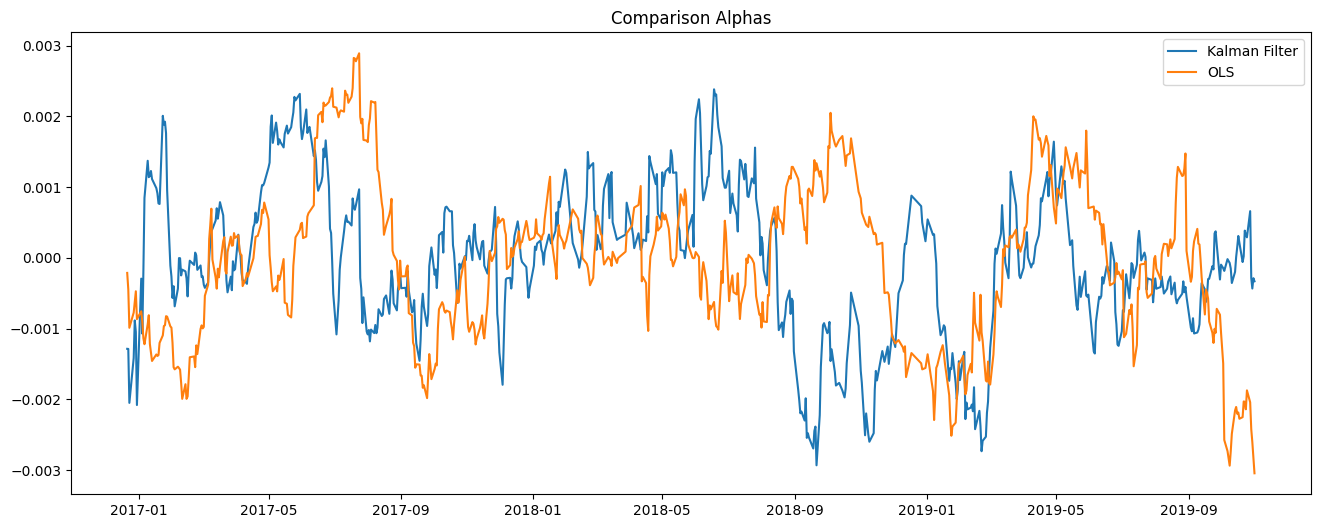

In [24]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, alphas, label="Kalman Filter")
plt.plot(ret_test["ols_alpha"], label="OLS")
plt.legend()
plt.title("Comparison Alphas")
plt.show()

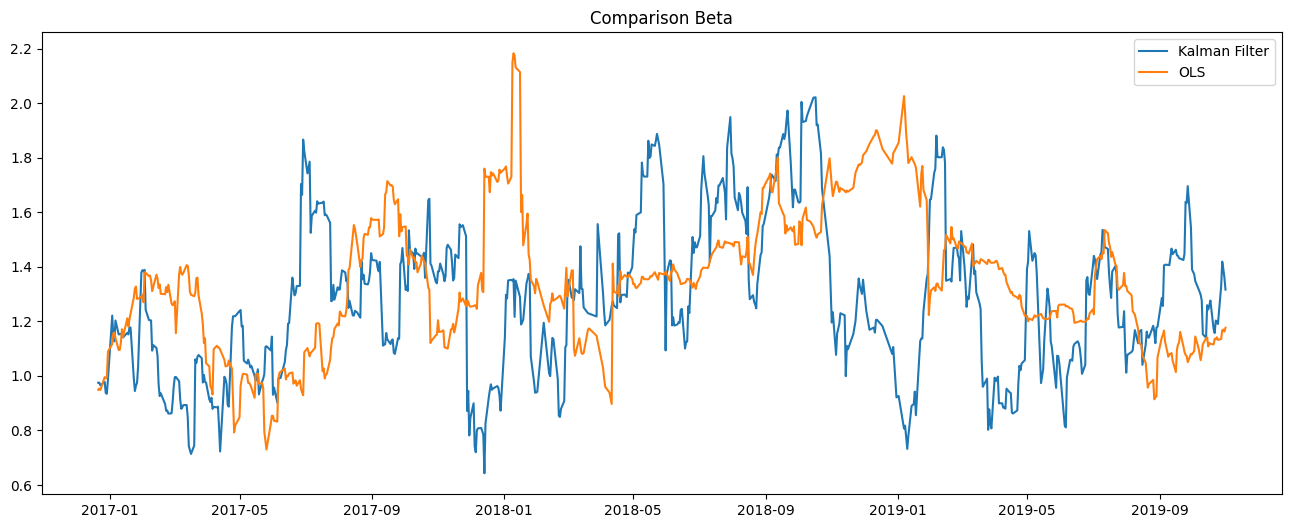

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, betas, label="Kalman Filter")
plt.plot(ret_test["ols_beta"], label="OLS")
plt.legend()
plt.title("Comparison Beta")
plt.show()

## Kalman Regression for the $\beta$

##### Calibration using MLE

In [26]:
KR = KF.Kalman_regression(ret_train[X], ret_train[Y])

alpha0, beta0 and var_eps initialized by OLS


In [27]:
dimens = 40
var_eps_x = np.linspace(1e-5, 2e-4, dimens)
var_eta_y = np.linspace(1e-5, 2e-4, dimens)
X_grid, Y_grid = np.meshgrid(var_eps_x, var_eta_y)
V_grid = np.ones((dimens, dimens))

for i, i_eps in enumerate(var_eps_x):
    for j, j_eta in enumerate(var_eta_y):
        KR.var_eps = i_eps
        KR.var_eta = j_eta
        KR.run()
        V_grid[j, i] = KR.loglikelihood

KR.set_OLS_params()
V = np.ones(dimens)
for j, j_eta in enumerate(var_eta_y):
    KR.var_eta = j_eta
    KR.run()
    V[j] = KR.loglikelihood

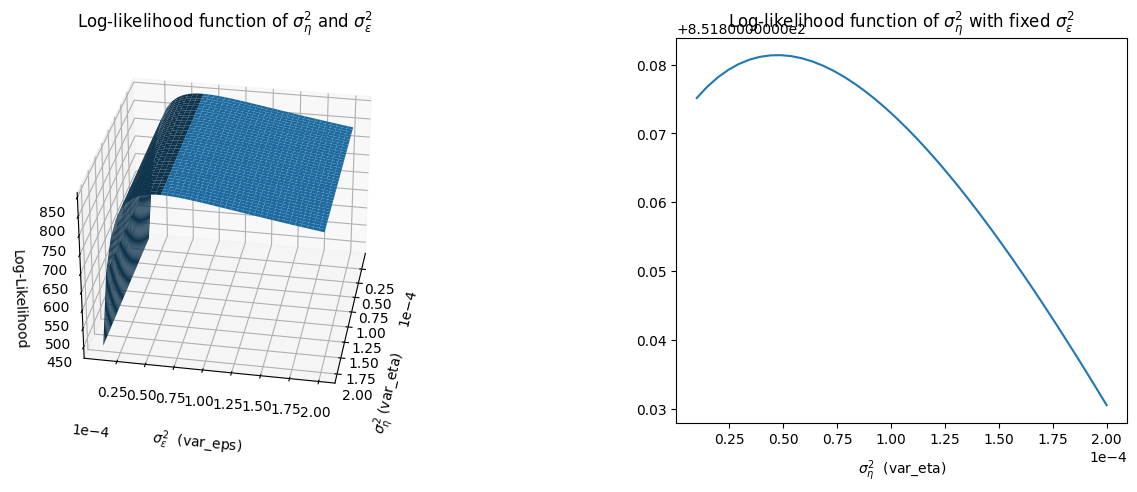

In [28]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])
ax = fig.add_subplot(gs[0], projection="3d")
ax2 = fig.add_subplot(gs[1])
ax.plot_surface(Y_grid, X_grid, V_grid)  # , cmap=cm.ocean
ax.set_title("Log-likelihood function of $\sigma_{\eta}^2$ and $\sigma_{\epsilon}^2$")
ax.set_xlabel("$\sigma_{\eta}^2$ (var_eta)                    ", labelpad=9)
ax.set_ylabel("$\sigma_{\epsilon}^2$  (var_eps)", labelpad=13)
ax.set_zlabel("Log-Likelihood", labelpad=7)
ax.view_init(30, 10)  # this function rotates the 3d plot
ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 2))
ax.ticklabel_format(axis="y", style="sci", scilimits=(-4, 2))
ax2.plot(var_eta_y, V)
ax2.set_title("Log-likelihood function of $\sigma_{\eta}^2$ with fixed $\sigma_{\epsilon}^2$")
ax2.set_xlabel("$\sigma_{\eta}^2$  (var_eta)", labelpad=8)
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.show()

In [29]:
KR.calibrate_MLE()

print("beta_last = ", KR.betas[-1], "P_last = ", KR.Ps[-1])
print("var_eta_MLE = ", KR.var_eta, "var_eps_MLE = ", KR.var_eps, "var_eps_OLS = ", var_eps_ols)

KR.run(ret_test[X], ret_test[Y])

print("The post-fit R squared is: ", KR.R2_post_fit)

Optimization converged successfully
var_eps = 6.250650685343185e-05, var_eta = 6.250079206412031e-05
beta_last =  1.0132897275907393 P_last =  0.01204813159170157
var_eta_MLE =  6.250079206412031e-05 var_eps_MLE =  6.250650685343185e-05 var_eps_OLS =  6.286775484858259e-05
The post-fit R squared is:  0.453226380319542


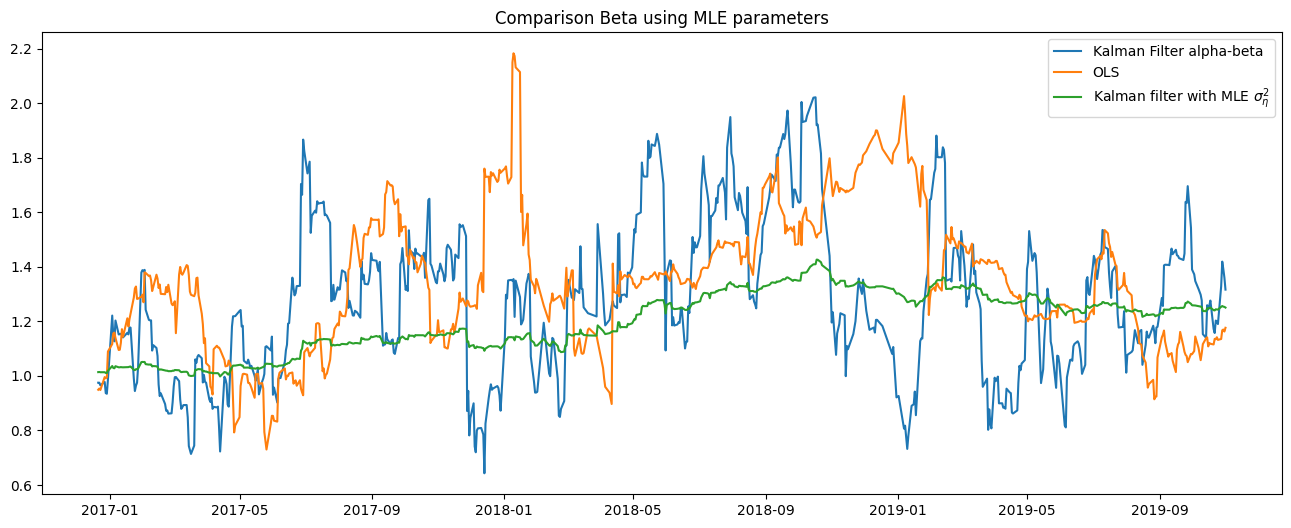

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, betas, label="Kalman Filter alpha-beta")
plt.plot(ret_test["ols_beta"], label="OLS")
plt.plot(ret_test.index, KR.betas, label="Kalman filter with MLE $\sigma_{\eta}^2$")
plt.legend()
plt.title("Comparison Beta using MLE parameters")
plt.show()

In [31]:
ret_test = ret_test.assign(Kalman_beta=KR.betas)
ret_test = ret_test.assign(Kalman_err=np.sqrt(KR.Ps))
ret_test.head()

,GOOGL,^GSPC,ols_beta,ols_std_err,ols_alpha,Kalman_beta,Kalman_err
Date,,,,,,,
2016-12-21,-0.003687,-0.002460,0.949317,0.154658,-0.000213,1.013967,0.109984
2016-12-22,-0.003108,-0.001865,0.953851,0.156574,-0.000446,1.014490,0.110230
2016-12-23,-0.002325,0.001251,0.948372,0.169485,-0.000989,1.013556,0.110497
2016-12-27,0.002633,0.002246,0.995708,0.175753,-0.000775,1.013613,0.110724
2016-12-28,-0.006640,-0.008392,0.991182,0.177171,-0.000622,1.010940,0.110244


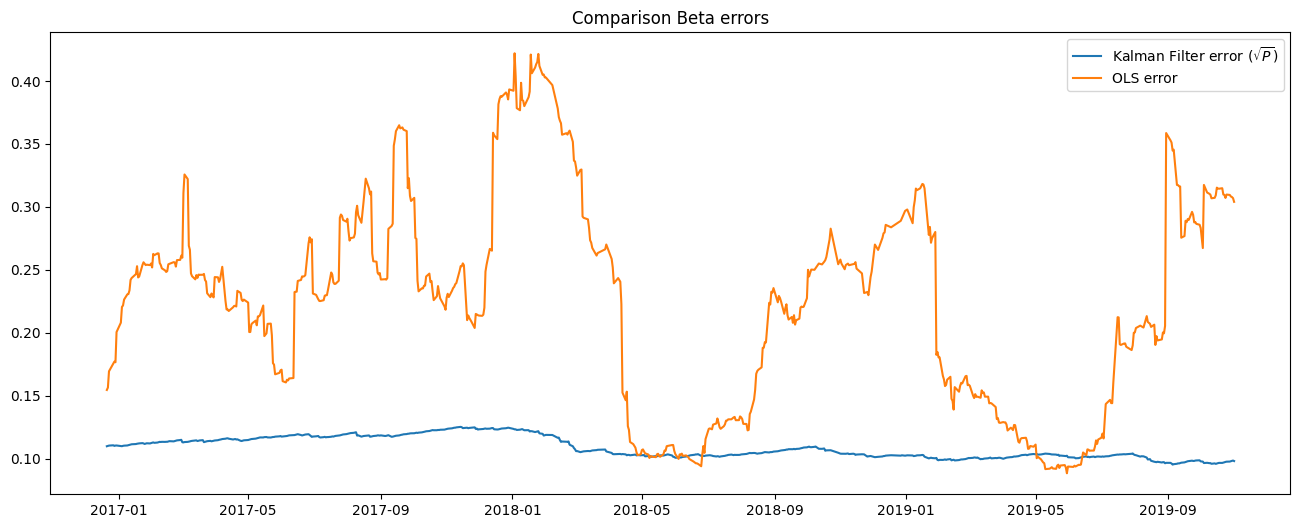

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test["Kalman_err"], label="Kalman Filter error ($\sqrt{P}$)")
plt.plot(ret_test["ols_std_err"], label="OLS error")
plt.legend()
plt.title("Comparison Beta errors")
plt.show()

Since the OLS error $\sqrt{ \frac{\sigma^2}{S_{xx}} }$ can be set arbitrarily small by simply choosing a bigger time window.

## What about the $R^2$ ?

In [33]:
KR.calibrate_R2(mode="pre-fit")

Optimization converged successfully
var_eta = 1e-15


In [34]:
KR.calibrate_R2(mode="post-fit")

Optimization converged successfully
var_eta = 1.0


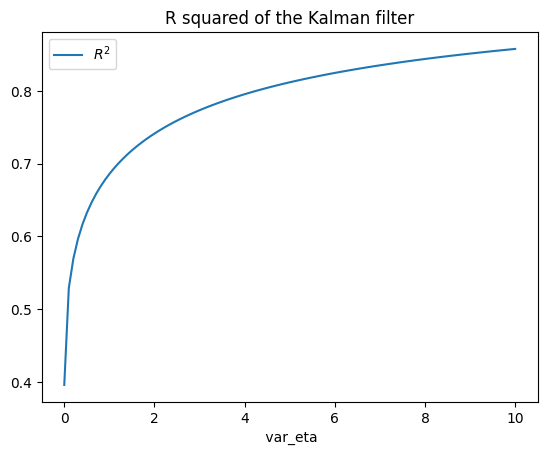

In [35]:
xx = np.linspace(0.000001, 10, 100)
RR2 = []
for i in xx:
    KR.run(var_eta=i, var_eps=var_eps_ols)
    RR2.append(KR.R2_post_fit)
plt.plot(xx, RR2, label="$R^2$")
plt.title("R squared of the Kalman filter")
plt.xlabel(" var_eta")
plt.legend()
plt.show()

In [36]:
var_eta_R2 = 200
KR.run(ret_test[X], ret_test[Y], var_eta=var_eta_R2, var_eps=var_eps_ols)

print("The post-fit R squared is: ", KR.R2_post_fit)

The post-fit R squared is:  0.9572452482415568


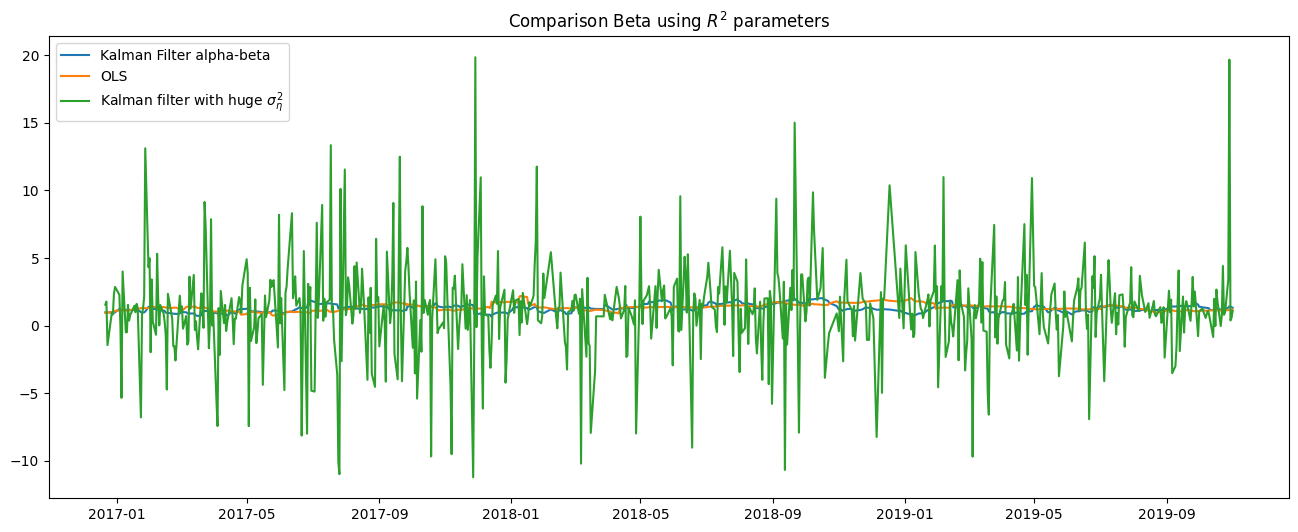

In [37]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, betas, label="Kalman Filter alpha-beta")
plt.plot(ret_test["ols_beta"], label="OLS")
plt.plot(ret_test.index, KR.betas, label="Kalman filter with huge $\sigma_{\eta}^2$")
plt.legend()
plt.title("Comparison Beta using $R^2$ parameters")
plt.show()

The $R^2$ is very close to 1, which means almost a perfect fit. However the obtained values of $\beta$ are unreasonable.